<h2>Forecasting Air temperature in jubail city with deep learning sequential models </h2>

Project steps :
- Aggregating time series data for easier analysis of trends over time
- Outlier detection and removal based on the Interquartile Range (IQR) method
- Spliting data to train-test and scaling it
- Preparing Time Series Data for Model Training
- Training and Evaluating Sequential Models
- Saving the model and making future predictions 

Source of the used data : https://datasource.kapsarc.org/explore/dataset/saudi-hourly-weather-data/information/?disjunctive.station_name&disjunctive.wind_direction_quality&disjunctive.wind_type&disjunctive.wind_speed_quality&disjunctive.sky_ceiling_quality&disjunctive.visibility_distance_quality&disjunctive.visibility_variability_quality&disjunctive.air_temperature_quality&disjunctive.air_temperature_dew_point_quality&disjunctive.atmospheric_sea_level_pressure_quality

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional
from keras.layers import LSTM


In [2]:
df=pd.read_csv('saudi-hourly-weather-data (2).csv',parse_dates=True,delimiter=";")
df.head()

,YEAR,station_country,station_name,station_id,observation_date,latitude,longitude,elevation,wind_direction_angle,wind_direction_angle_units,...,air_temperature,air_temperature_units,air_temperature_quality,air_temperature_dew_point,air_temperature_dew_point_units,air_temperature_dew_point_quality,atmospheric_sea_level_pressure,atmospheric_sea_level_pressure_units,atmospheric_sea_level_pressure_quality,GEOPOINT
0,2024,SA,JUBAIL,40419499999,2024-03-18T22:00:00+03:00,27.039028,49.405083,7.92,180,ANGULAR DEGREES,...,26.0,DEGREES CELSIUS,Passed all quality control checks,16.0,DEGREES CELSIUS,Passed all quality control checks,9999.9,HECTOPASCALS,Passed gross limits check if element is present,"27.039028000000002, 49.405083000000005"
1,2024,SA,JUBAIL,40419499999,2024-03-18T21:00:00+03:00,27.039028,49.405083,7.92,160,ANGULAR DEGREES,...,26.0,DEGREES CELSIUS,Passed all quality control checks,15.0,DEGREES CELSIUS,Passed all quality control checks,9999.9,HECTOPASCALS,Passed gross limits check if element is present,"27.039028000000002, 49.405083000000005"
2,2024,SA,JUBAIL,40419499999,2024-03-18T08:00:00+03:00,27.039028,49.405083,7.92,999,ANGULAR DEGREES,...,22.0,DEGREES CELSIUS,Passed all quality control checks,18.0,DEGREES CELSIUS,Passed all quality control checks,9999.9,HECTOPASCALS,Passed gross limits check if element is present,"27.039028000000002, 49.405083000000005"
3,2024,SA,JUBAIL,40419499999,2024-03-03T19:00:00+03:00,27.039028,49.405083,7.92,120,ANGULAR DEGREES,...,19.0,DEGREES CELSIUS,Passed all quality control checks,10.0,DEGREES CELSIUS,Passed all quality control checks,9999.9,HECTOPASCALS,Passed gross limits check if element is present,"27.039028000000002, 49.405083000000005"
4,2024,SA,JUBAIL,40419499999,2024-03-03T18:00:00+03:00,27.039028,49.405083,7.92,120,ANGULAR DEGREES,...,19.0,DEGREES CELSIUS,Passed all quality control checks,9.0,DEGREES CELSIUS,Passed all quality control checks,9999.9,HECTOPASCALS,Passed gross limits check if element is present,"27.039028000000002, 49.405083000000005"


In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29375 entries, 0 to 29374
Data columns (total 35 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   YEAR                                    29375 non-null  int64  
 1   station_country                         29375 non-null  object 
 2   station_name                            29375 non-null  object 
 3   station_id                              29375 non-null  int64  
 4   observation_date                        29375 non-null  object 
 5   latitude                                29375 non-null  float64
 6   longitude                               29375 non-null  float64
 7   elevation                               29375 non-null  float64
 8   wind_direction_angle                    29375 non-null  int64  
 9   wind_direction_angle_units              29375 non-null  object 
 10  wind_direction_quality                  29375 non-null  ob

Aggregate time series data for easier analysis of trends over time

In [4]:
df['observation_date']=pd.to_datetime(df['observation_date'])
df['CDate']=df['observation_date'].dt.to_period('d').dt.to_timestamp()
df_C=df.groupby('CDate').agg({'air_temperature':'mean'})

C:\Users\samar\AppData\Local\Temp\ipykernel_11620\2324160946.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['CDate']=df['observation_date'].dt.to_period('d').dt.to_timestamp()


In [6]:
df_C.tail()

,air_temperature
CDate,
2024-02-13,18.333333
2024-02-15,19.500000
2024-02-18,20.000000
2024-03-03,19.000000
2024-03-18,24.666667


<Axes: xlabel='CDate', ylabel='air_temperature'>

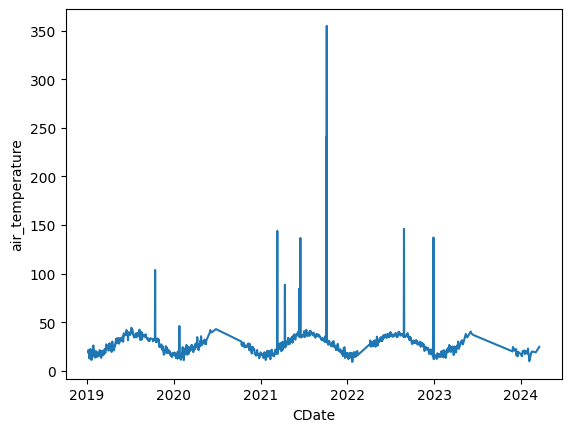

In [7]:
sns.lineplot(data=df_C,x=df_C.index,y=df_C['air_temperature'])

In [8]:
df_C.shape

(1363, 1)

Outlier detection and removal based on the Interquartile Range (IQR) method

In [9]:

# Calculate Q1 and Q3
Q1 = df_C['air_temperature'].quantile(0.25)
Q3 = df_C['air_temperature'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_C = df_C[(df_C['air_temperature'] >= lower_bound) & (df_C['air_temperature'] <= upper_bound)]




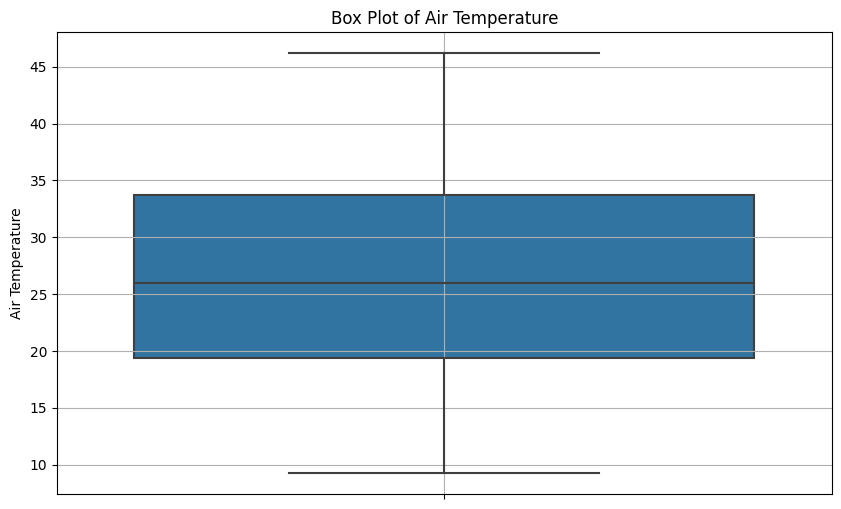

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(y=df_C['air_temperature'])
plt.title('Box Plot of Air Temperature')
plt.ylabel('Air Temperature')
plt.grid(True) 
plt.show()


<Axes: xlabel='CDate', ylabel='air_temperature'>

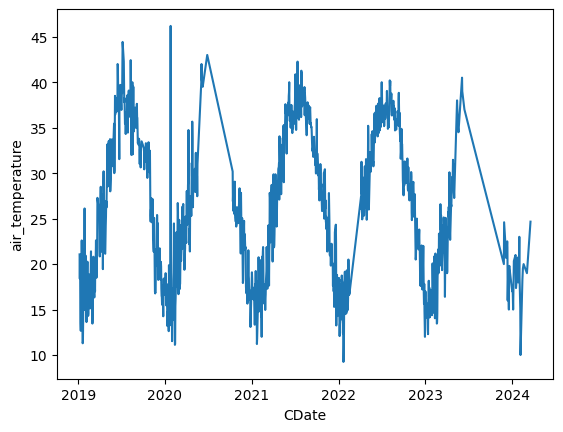

In [11]:
sns.lineplot(data=df_C,x=df_C.index,y=df_C['air_temperature'])

<h4>Forecasting with RNN (LSTM) Model </h4> </br> LSTM is aspecial kind of recurrent neural network (RNN) designed to handle the long-term dependencies present in sequential data. LSTMs can learn to remember information for long periods of time .

In [12]:
train=df_C[:round(len(df_C)*70/100)]
test=df_C[round(len(df_C)*70/100):]

In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train= scaler.fit_transform(train)
scaled_test=scaler.fit_transform(test)

 Transform time series data into a supervised learning format by generating input sequences of a specified length and their corresponding target values.to allow models to learn patterns and make predictions based on previous observations in the data.

In [14]:
# Create input dataset 
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(scaled_train,LOOK_BACK)
X_test, y_test = create_dataset(scaled_test,LOOK_BACK)
# Print data shape
print( X_train.shape)
print( y_train.shape)
print( X_test.shape) 
print( y_test.shape)

(917, 30, 1)
(917, 1)
(376, 30, 1)
(376, 1)


In [40]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape= (([X_train.shape[1], X_train.shape[2]]))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
# fit model
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 32, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_LSTM= fit_model(model)
#model.fit(X_train, y_train,epochs=50)

Epoch 1/100
23/23 [==============================] - 2s 33ms/step - loss: 0.1063 - val_loss: 0.0105
Epoch 2/100
23/23 [==============================] - 0s 21ms/step - loss: 0.0122 - val_loss: 0.0090
Epoch 3/100
23/23 [==============================] - 0s 19ms/step - loss: 0.0140 - val_loss: 0.0073
Epoch 4/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0164 - val_loss: 0.0087
Epoch 5/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0142 - val_loss: 0.0072
Epoch 6/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0119 - val_loss: 0.0067
Epoch 7/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0105 - val_loss: 0.0062
Epoch 8/100
23/23 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0059
Epoch 9/100
23/23 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 10/100
23/23 [==============================] - 0s 21ms/step - loss: 0.0102 - val_loss: 0.0059

In [43]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_LSTM = prediction(model)

12/12 [==============================] - 0s 7ms/step


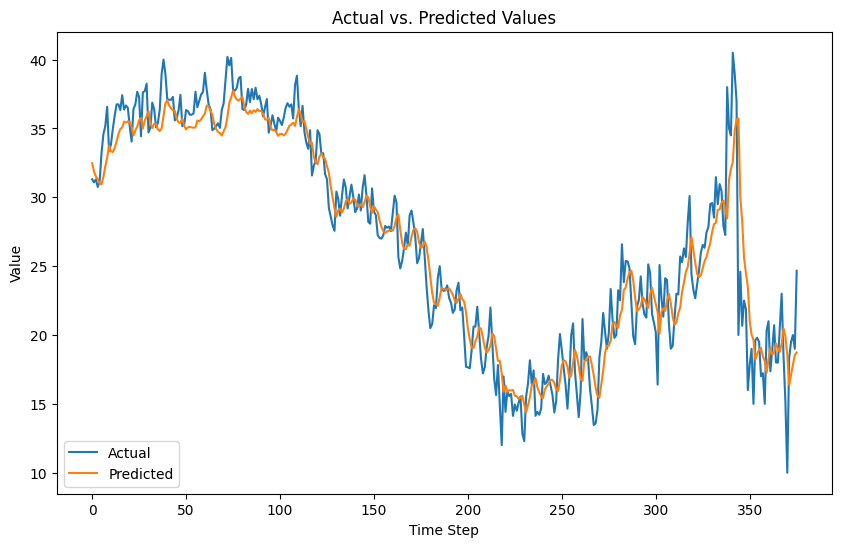

In [44]:
import matplotlib.pyplot as plt
range_future = len(prediction_LSTM)


y_testI = scaler.inverse_transform(y_test)
y_trainI = scaler.inverse_transform(y_train)


plt.figure(figsize=(10, 6))
plt.plot(np.arange(range_future), np.array(y_testI), label='Actual')
plt.plot(np.arange(range_future), np.array((prediction_LSTM)), label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [45]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions -actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
    

evaluate_prediction(prediction_LSTM, y_testI, 'LSTM')

LSTM:
Mean Absolute Error: 1.7048
Root Mean Square Error: 2.3164



<h2>GRU model</h2>

Gated Recurrent Unit (GRU) networks are another type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. Similar to Long Short-Term Memory (LSTM) networks, GRUs use gates to control the flow of information, but they have a simpler architecture.

In [21]:

# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
     
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [22]:
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 64)            12864     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37889 (148.00 KB)
Trainable params: 37889 (148.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 32, shuffle = False, 
                        callbacks = [early_stop])
    return history
history_gru = fit_model(model_gru)


Epoch 1/100
23/23 [==============================] - 5s 57ms/step - loss: 0.0643 - val_loss: 0.0092
Epoch 2/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0127 - val_loss: 0.0047
Epoch 3/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0082 - val_loss: 0.0049
Epoch 4/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 5/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0089 - val_loss: 0.0048
Epoch 6/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0098 - val_loss: 0.0054
Epoch 7/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0105 - val_loss: 0.0053
Epoch 8/100
23/23 [==============================] - 1s 28ms/step - loss: 0.0112 - val_loss: 0.0050
Epoch 9/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0113 - val_loss: 0.0049
Epoch 10/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0118 - val_loss: 0.0050

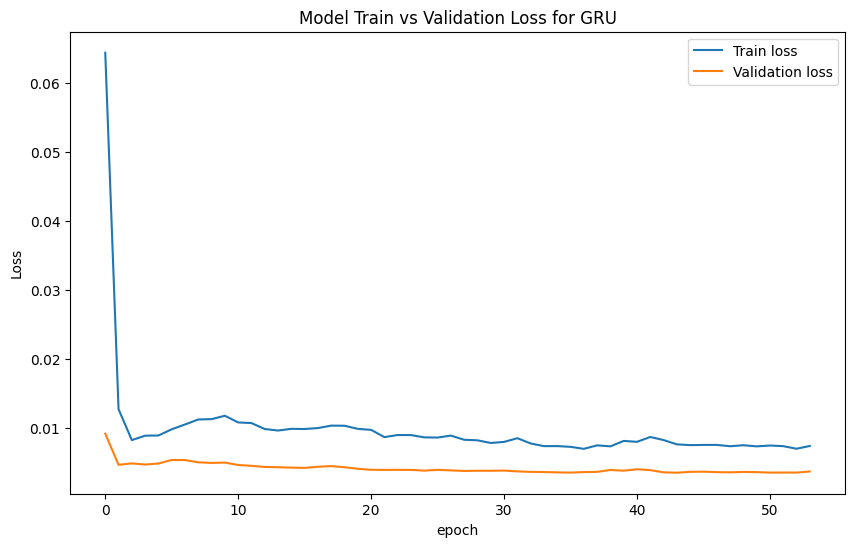

In [24]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for '+ model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')


In [25]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)


12/12 [==============================] - 1s 6ms/step


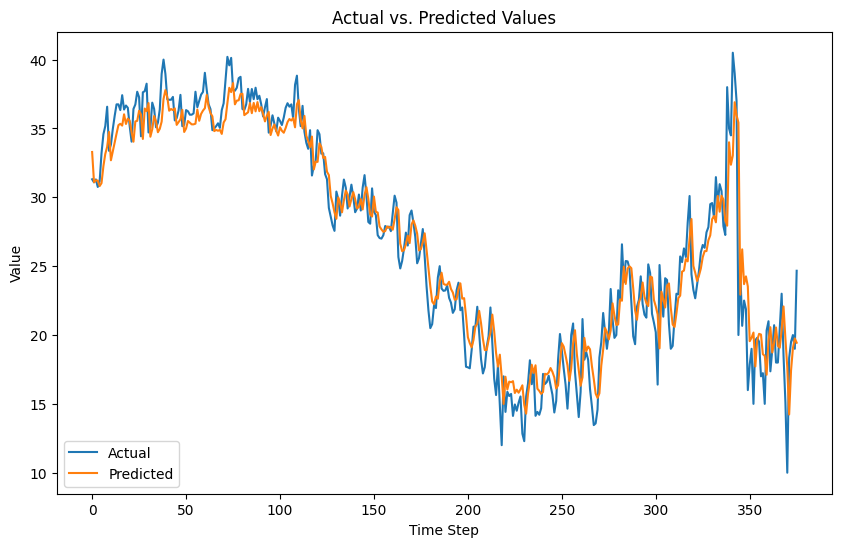

In [27]:
import matplotlib.pyplot as plt
range_future = len(prediction_gru)

y_testI = scaler.inverse_transform(y_test)
y_trainI = scaler.inverse_transform(y_train)

# Assuming you have y_test defined
plt.figure(figsize=(10, 6))
plt.plot(np.arange(range_future), np.array(y_testI), label='Actual')
plt.plot(np.arange(range_future), np.array(prediction_gru), label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [28]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions -actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
    

evaluate_prediction(prediction_gru, y_testI, 'GRU')

GRU:
Mean Absolute Error: 1.5485
Root Mean Square Error: 2.1438



In [29]:
model_gru.save('myGRU_model.h5')

C:\Users\samar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2>BiLSTM model</h2>

Bidirectional LSTMs (BiLSTMs) are a variant of LSTM networks that process input sequences in both directions: from the beginning to the end and from the end to the beginning. This allows BiLSTMs to capture context from both past and future elements in the sequence, making them particularly effective for tasks where information from both directions is important.

In [30]:

def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(
              LSTM(units = units, return_sequences=True), 
              input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_bilstm = create_bilstm(64)

In [31]:
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 128)           33792     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 132737 (518.50 KB)
Trainable params: 132737 (518.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)# if the validation loss does not improve for 15 consecutive epochs, training will halt.
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 32, shuffle = False, 
                        callbacks = [early_stop])
    return history


history_bilstm = fit_model(model_bilstm)

Epoch 1/100
23/23 [==============================] - 9s 104ms/step - loss: 0.0483 - val_loss: 0.0112
Epoch 2/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0265 - val_loss: 0.0117
Epoch 3/100
23/23 [==============================] - 1s 37ms/step - loss: 0.0191 - val_loss: 0.0089
Epoch 4/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0137 - val_loss: 0.0081
Epoch 5/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0128 - val_loss: 0.0078
Epoch 6/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0137 - val_loss: 0.0075
Epoch 7/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0143 - val_loss: 0.0072
Epoch 8/100
23/23 [==============================] - 1s 36ms/step - loss: 0.0140 - val_loss: 0.0068
Epoch 9/100
23/23 [==============================] - 1s 39ms/step - loss: 0.0125 - val_loss: 0.0064
Epoch 10/100
23/23 [==============================] - 1s 38ms/step - loss: 0.0118 - val_loss: 0.006

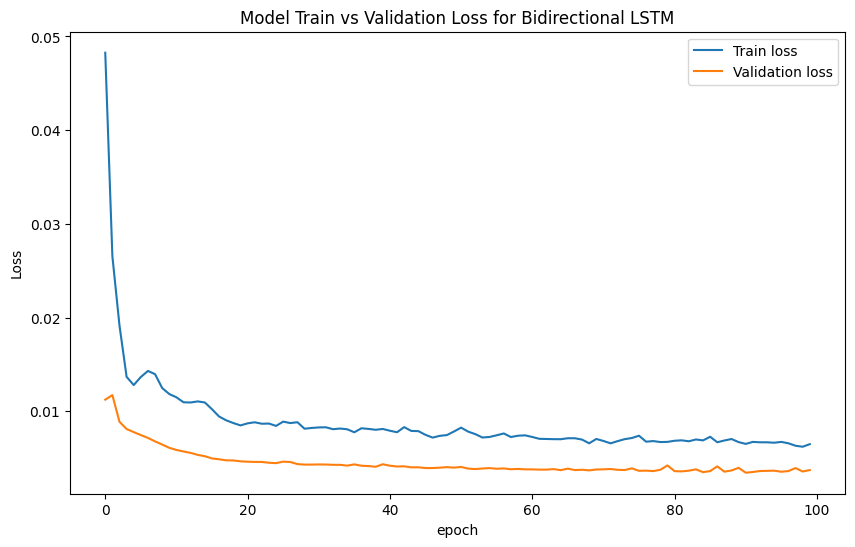

In [33]:
plot_loss (history_bilstm, 'Bidirectional LSTM')

In [34]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)


12/12 [==============================] - 1s 12ms/step


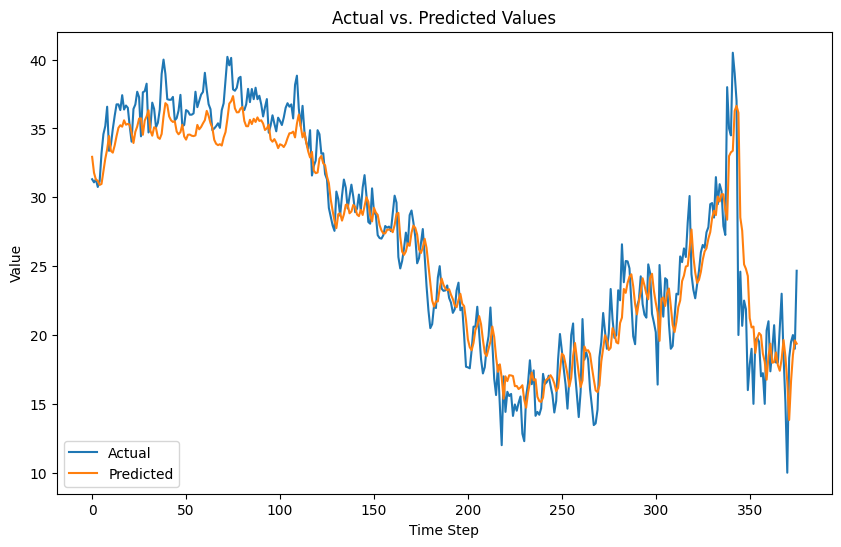

In [35]:
range_future = len(prediction_bilstm)

# Assuming you have y_test defined
plt.figure(figsize=(10, 6))
plt.plot(np.arange(range_future), np.array(y_testI), label='Actual')
plt.plot(np.arange(range_future), np.array(prediction_bilstm), label='Predicted')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

In [36]:
evaluate_prediction(prediction_bilstm, y_testI, 'bilstm')

bilstm:
Mean Absolute Error: 1.7477
Root Mean Square Error: 2.3223



Evaluates the performance of the three models to determine the best model 

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate MSE, RMSE, and MAE for each model
mse_modelBilstm = np.square(prediction_bilstm -y_testI ).mean()
rmse_modelBilstm = np.sqrt(mse_modelBilstm)
mae_modelBilstm = np.abs(prediction_bilstm -y_testI ).mean()


mse_modelGRU = np.square(prediction_gru - y_testI).mean()
rmse_modelGRU = np.sqrt(mse_modelGRU)
mae_modelGRU = np.abs(prediction_gru - y_testI).mean()


mse_modelLSTM = np.square(prediction_LSTM-y_testI).mean()
rmse_modelLSTM = np.sqrt(mse_modelLSTM)
mae_modelLSTM = np.abs(prediction_LSTM-y_testI).mean()


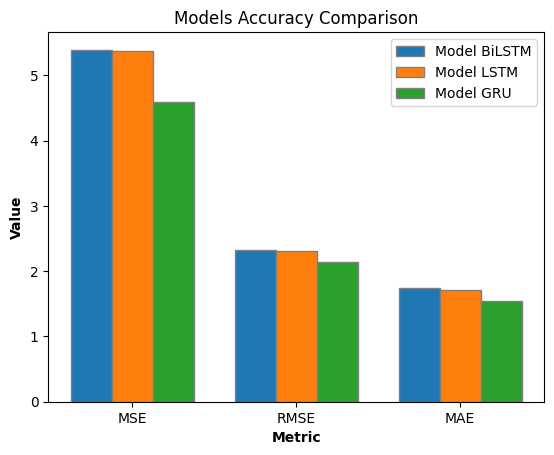

In [47]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MSE', 'RMSE', 'MAE']
values_modelBilstm = [mse_modelBilstm, rmse_modelBilstm, mae_modelBilstm]
values_modelGRU = [mse_modelGRU, rmse_modelGRU, mae_modelGRU]
values_modelLSTM = [mse_modelLSTM, rmse_modelLSTM, mae_modelLSTM]


barWidth = 0.25


r1 = np.arange(len(metrics))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


plt.bar(r1, values_modelBilstm, width=barWidth, edgecolor='grey', label='Model BiLSTM')
plt.bar(r2, values_modelLSTM, width=barWidth, edgecolor='grey', label='Model LSTM')
plt.bar(r3, values_modelGRU, width=barWidth, edgecolor='grey', label='Model GRU')


plt.xlabel('Metric', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(metrics))], metrics)


plt.ylabel('Value', fontweight='bold')
plt.title('Models Accuracy Comparison')
plt.legend()


plt.show()


the GRU model outperforms the BiLSTM and LSTM models indicating the best performance as it means the model's predictions are closer to the actual values

Use the Model for prediction 

In [71]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model



new_dates = pd.date_range(start='2024-04-01', end='2024-11-29')  
new_data = pd.DataFrame(new_dates, columns=['Date'])


new_data['day_of_year'] = new_data['Date'].dt.dayofyear
new_data['sin_day'] = np.sin(new_data['day_of_year'] * (2 * np.pi / 365))


scaler1 = MinMaxScaler()
scaler1.fit(new_data[['sin_day']])
new_data_scaled = scaler1.transform(new_data[['sin_day']]) 


X_new = []
for i in range(len(new_data_scaled) - 30):
    X_new.append(new_data_scaled[i:i+30])

X_new = np.array(X_new)

X_new = X_new.reshape(-1, 30, 1)  
model = load_model('myGRU_model.h5')


predictions = model.predict(X_new)


predictions_inversed = scaler.inverse_transform(predictions)
print(predictions_inversed)


7/7 [==============================] - 1s 9ms/step
[[37.66249  ]
 [37.551853 ]
 [37.437653 ]
 [37.31991  ]
 [37.198658 ]
 [37.073925 ]
 [36.945744 ]
 [36.814144 ]
 [36.679157 ]
 [36.54083  ]
 [36.399178 ]
 [36.25425  ]
 [36.10608  ]
 [35.95471  ]
 [35.800167 ]
 [35.642498 ]
 [35.48175  ]
 [35.317955 ]
 [35.15116  ]
 [34.981407 ]
 [34.808746 ]
 [34.63322  ]
 [34.454872 ]
 [34.273754 ]
 [34.089916 ]
 [33.9034   ]
 [33.71427  ]
 [33.522564 ]
 [33.328346 ]
 [33.131664 ]
 [32.93257  ]
 [32.731133 ]
 [32.52739  ]
 [32.321415 ]
 [32.11326  ]
 [31.902988 ]
 [31.690657 ]
 [31.476334 ]
 [31.26007  ]
 [31.041939 ]
 [30.822008 ]
 [30.600336 ]
 [30.37699  ]
 [30.152037 ]
 [29.925545 ]
 [29.697586 ]
 [29.46823  ]
 [29.237543 ]
 [29.005604 ]
 [28.772474 ]
 [28.538237 ]
 [28.302961 ]
 [28.06672  ]
 [27.829594 ]
 [27.59165  ]
 [27.35297  ]
 [27.113626 ]
 [26.873703 ]
 [26.633268 ]
 [26.392405 ]
 [26.15119  ]
 [25.9097   ]
 [25.668016 ]
 [25.426214 ]
 [25.184376 ]
 [24.942575 ]
 [24.700893 ]
 [24.459412

In [73]:

prediction_dates = pd.date_range(start='2024-08-30', periods=len(predictions), freq='D')

results_df = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted Temperature': predictions_inversed.flatten() 
})


print(results_df)

          Date  Predicted Temperature
0   2024-08-30              37.662491
1   2024-08-31              37.551853
2   2024-09-01              37.437653
3   2024-09-02              37.319908
4   2024-09-03              37.198658
..         ...                    ...
208 2025-03-26              17.127266
209 2025-03-27              17.320601
210 2025-03-28              17.516344
211 2025-03-29              17.714437
212 2025-03-30              17.914822

[213 rows x 2 columns]


In [74]:
results_df.to_csv('predictedJubail_temperatures.csv', index=False)

